In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
(1- (5/11)**2) - (6/11)**2

0.4958677685950414

In [3]:
1-(1/7)**2-(6/7)**2

0.24489795918367352

In [8]:
x = np.arange(0, 3, 1)
y = np.arange(4, 6, 1)
# xx, yy = np.meshgrid(x, y, sparse=True)
x, y

(array([0, 1, 2]), array([4, 5]))

In [18]:
np.meshgrid([1,1,1,4],[0,0,1])

[array([[1, 1, 1, 4],
        [1, 1, 1, 4],
        [1, 1, 1, 4]]),
 array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 1]])]

# Decision Trees

## Success Criteria

Today I will be successful by...

1. Today I will be successful if I can…
2. Define root, parent, child, leaf node on a decision tree
3. Explain how a Decision Tree determines a split
4. Calculate mini impurity and Shannon entropy of example trees
5. Express a danger of a fully grown decision tree in terms of bias/variance
6. Explain the following parameters of a decision tree:
        - criterion 
        - max_depth
        - min_impurity_split


### Build Decision Tree and Pruning Pseudocode

Do this together

In [19]:
def factorial(n):
    prod = 1
    
    for i in range(2,n+1):
        prod *= i
        print(prod)
    
    return prod
factorial(5)

2
6
24
120


120

In [22]:
def rec_factorial(n):
    if n <= 1:
        return 1
    print(n)
    return n * rec_factorial(n-1)

rec_factorial(5)

5
4
3
2


120

In [21]:
def power(base, exp):
    if exp == 0:
        return 1
    return base * power(base, exp-1)

### Titanic data 

In [23]:
titanic_df = pd.read_csv('data/train.csv')

In [26]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
survival_sex = pd.crosstab(titanic_df.Survived, [titanic_df.Sex])
survival_sex

Sex,female,male
Survived,,
0,81,468
1,233,109


In [36]:
survival_sex / survival_sex.sum(axis=0)

Sex,female,male
Survived,,
0,0.257962,0.811092
1,0.742038,0.188908


### Lets start with age

In [37]:
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 1, 'female': 0})

In [38]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C


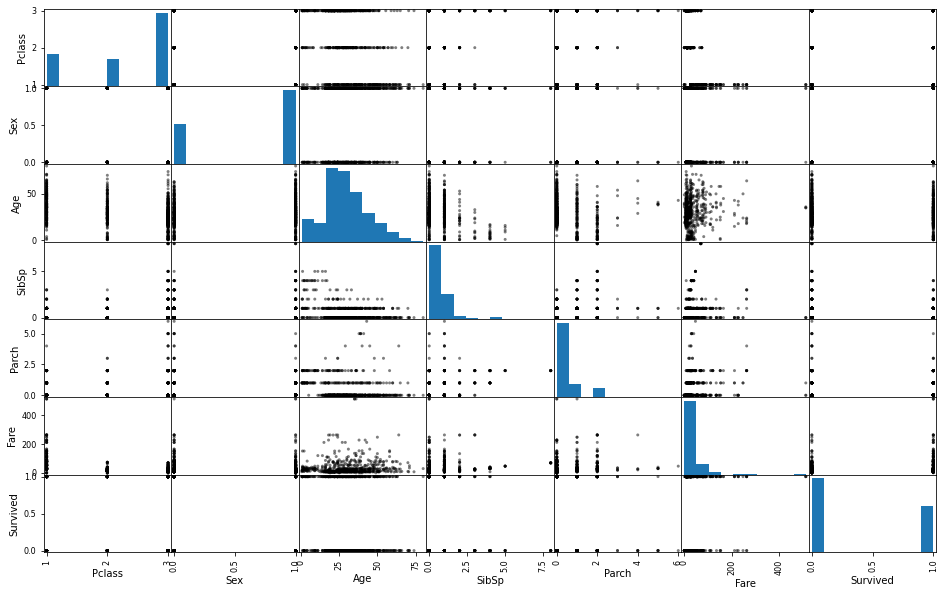

In [40]:
pd.plotting.scatter_matrix(titanic_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']],
                           figsize = (16, 10), color='k');

In [41]:
titanic_df['Survived'].sum(), (titanic_df['Survived']==0).sum(), titanic_df['Survived'].count()

(342, 549, 891)

342 Survived, 549 Did not, 891 Total passengers

## Gini Impurity
$$H(X) = 1 - \sum_i p_i^2$$

### Initial Gini impurity of Training Data Survived column:

In [48]:
not_survived = (titanic_df['Survived'] == 0).sum()
survived = (titanic_df['Survived'] == 1).sum()
passengers = titanic_df['Survived'].count()
passengers

891

In [49]:
p_survived = survived/passengers
p_not_survived = not_survived/passengers

gini_impurity = 1 - (p_survived)**2 - (p_not_survived)**2
gini_impurity

0.47301295786144276

# Shannon Entropy:

$$H(X) = -\sum_i p_i \log_2{p_i}$$

### Initial Entropy:

In [51]:
import math

entropy_impurity = -p_survived * math.log(p_survived,2) - p_not_survived * math.log(p_not_survived,2)
entropy_impurity

0.9607079018756469

## Let's calculate the information gain from splitting on Sex using Gini Impurity:

### Gini Impurity of Male Leaf:<br>
109 survived, 468 did not and a total of 577 male passengers
$$H(X) = 1 - \sum_i p_i^2$$

In [52]:
survival_sex

Sex,female,male
Survived,,
0,81,468
1,233,109


In [64]:
p_survived_male = (survival_sex/survival_sex.sum(axis=0)).male[1]
p_not_survived_male = (survival_sex/survival_sex.sum(axis=0)).male[0]

gini_impurity_male = 1 - (p_survived_male)**2 - (p_not_survived_male)**2
gini_impurity_male 


0.3064437162277842

### Gini Impurity of Female Leaf: <br> 
233 survived, 81 did not, and a total of 314 female passengers

In [65]:
p_survived_female = (survival_sex/survival_sex.sum(axis=0)).female[1]
p_not_survived_female = (survival_sex/survival_sex.sum(axis=0)).female[0]

gini_impurity_female = 1 - (p_survived_female)**2 - (p_not_survived_female)**2
gini_impurity_female 

0.3828350034484158

### Information Gain from Splitting by Sex using Gini Impurity:

$$\text{IG}(S, C) = H(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} H(C_i)$$

891 total passengers <br>
577 male passengers <br>
314 female passengers <br>

Initial impurity:  0.47<br>
Impurity of Male Leaf:  0.31<br>
Impurity of Female Leaf: 0.38

In [70]:
p_female = survival_sex.sum(axis=0)['female']/passengers
p_male = survival_sex.sum(axis=0)['male']/passengers

In [71]:
gini_impurity - gini_impurity_male * p_male - gini_impurity_female * p_female

0.13964795747285233